In [2]:
# coding=utf-8
from scapy.all import *
import binascii
import struct
import time

from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import plot
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

import decimal
from decimal import Decimal
import crcmod
import libnum

from scapy.layers.inet import IP, UDP
from scapy.layers.l2 import Ether

import sys
#sys.path.append('/home/xalanaseon/scapy-cip-enip')
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/home/xalanaseon/scapy-cip-enip')
#from cip import CIP, CIP_Path
#import cip
import numpy as np

packets = []

s_time = 0
c_time = 0
duration = 10 #time record in seconds
bounds = np.load("np_bounds_CRITIS_dst.npy")
print(bounds)
Variances = []
peaks = bounds[:,0]
height = bounds[:,1]
for i in range(len(peaks)):
    # SUM((Xi-E[X])^2)/N
    S2 = (((bounds[i,0]-bounds[i,2])**2) + ((bounds[i,0]-bounds[i,3])**2))/2
    Variances.append(np.sqrt(S2))
        
print("variances = ",Variances)

N=100
queue = []
Detection_count = 0
Probability = 0

timespan = []
detected = []


### Convert ip address string to integer
def ip2long(ip):
    """
    Convert an IP string to long
    """
    packedIP = socket.inet_aton(ip)
    return struct.unpack("!L", packedIP)[0]

def packet_analysis(pkt):
    if IP in pkt and TCP in pkt:
        global s_time
        global c_time
        global Probability
        global queue
        if s_time == 0:
            s_time = pkt.time
            c_time = pkt.time
            print(type(float(pkt.time)))
        #if len(pkt[TCP].payload) > 6:
        #print(pkt[CIP].SERVICE_CODES[pkt[CIP].service])
        #pkt.show()
        if(pkt[TCP].dport == 502):
            queue = [x for x in queue if x+60 > pkt.time]
            c_time = pkt.time
            X_queue = [x for x in queue]
            X_queue.append(pkt.time)
            #print(len(X_queue))
            if len(X_queue) < 100:
                queue.append(pkt.time)  
            else:
                X_Q = np.asarray(X_queue)
                #print(X_Q)
                X = np.diff(X_Q).reshape(-1,1)
                #print(X)
                X_plot = np.linspace(-0.0, 0.1, 1000)[:, np.newaxis]
                #print(X_plot)
                kde = KernelDensity(kernel='gaussian', bandwidth=0.0005).fit(X)
                log_dens = kde.score_samples(X_plot)
                #print(kde.get_params())
                dens = np.exp(log_dens)/1000
                c_peaks, _ = find_peaks(dens, height=0.001)
                nppeaks = np.hstack((X_plot[c_peaks],dens[c_peaks].reshape(-1,1)))
                
                queue.append(pkt.time) 
                Probability = 0.0
                p_list = []
                for pks in nppeaks:
                    if pks[1] > 0.01:
                        peak_index = np.abs(peaks - pks[0]).argmin()
                        Amplitude = np.abs(height[peak_index] - pks[1])/height[peak_index]
                        Distances = np.abs(peaks[peak_index] - pks[0])/Variances[peak_index]
                        if Distances >= 1:
                            p_list.append(Distances)
                            #Chebychev cannot be used at k below 1.0
                if len(p_list) > 0:
                    #print(nppeaks)
                    k = np.max(p_list)
                    #print("k value ",k)
                    #Confidence = Pr[All] - Pr[Occur] , Pr Occur = 1/k^2
                    Pr_occur = 1/(k**2)
                    #print("Pr data present ",Pr_occur)
                    Probability = 1 - Pr_occur
                    detected.append([pkt.time,1,Probability]) 
                    #print("Sequence number ",pkt[TCP].seq)
                    #print(pkt.time)
                    #print(datetime.utcfromtimestamp(pkt.time).strftime('%Y-%m-%d %H:%M:%S'))
                    #print("Detection Confidences ",Probability)
                else:
                    detected.append([pkt.time,0,0.0]) 


            #print(time.localtime(pkt.time))
                    

[[7.86786787e-02 1.59268458e-03 7.76980026e-02 7.94950113e-02
  3.18536917e-04]
 [9.42942943e-02 3.02293411e-01 9.33261405e-02 9.51982190e-02
  6.04586823e-02]
 [1.06756757e-01 7.94810024e-04 1.05802108e-01 1.07407880e-01
  2.21923981e-04]
 [1.09909910e-01 7.43077224e-02 1.08906792e-01 1.10760036e-01
  1.48615445e-02]
 [1.25375375e-01 7.97865651e-04 1.24350329e-01 1.26143829e-01
  1.59573130e-04]
 [1.34234234e-01 7.91831506e-04 1.33256749e-01 1.35066827e-01
  1.58366334e-04]
 [1.40690691e-01 1.08651588e-03 1.39257680e-01 1.41758661e-01
  2.17303177e-04]]
variances =  [0.0009022540179835526, 0.0009365900214421905, 0.0008171032979643106, 0.0009297744292981334, 0.0009058806505805672, 0.0009079336401112226, 0.0012637408443374365]


In [3]:
try:
    start_t = time.time()
    sniff(offline='DataSet/captures1_v2/captures1_v2/modbusQuery2Flooding/eth2dump-modbusQuery2Flooding1m-0,5h_1.pcap', prn=packet_analysis, store=0, filter="dst host 172.27.224.250")
    #sniff(offline='DataSet/captures1_v2/captures1_v2/mitm/eth2dump-mitm-change-1m-0,5h_1.pcap', prn=packet_analysis, store=0, filter="host 172.27.224.70 and dst 172.27.224.250")
    #sniff(offline='DataSet/Dex2019_0002_attack3.pcap', prn=packet_analysis, store=0, count=100000, filter="src host 192.168.1.10 and dst host 192.168.1.20")
    print('Completed')
    stop_t  = time.time()
    delta_time = stop_t - start_t
    print(delta_time)

except Exception as sniff_dec_err:
    traceback.print_exc()
    print(str(sniff_dec_err))

<class 'float'>
Completed
4080.174121618271


<ipython-input-4-759b9083226f>:8: DeprecationWarning: an integer is required (got type decimal.Decimal).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  dates=[datetime.fromtimestamp(ts[0]) for ts in detected]


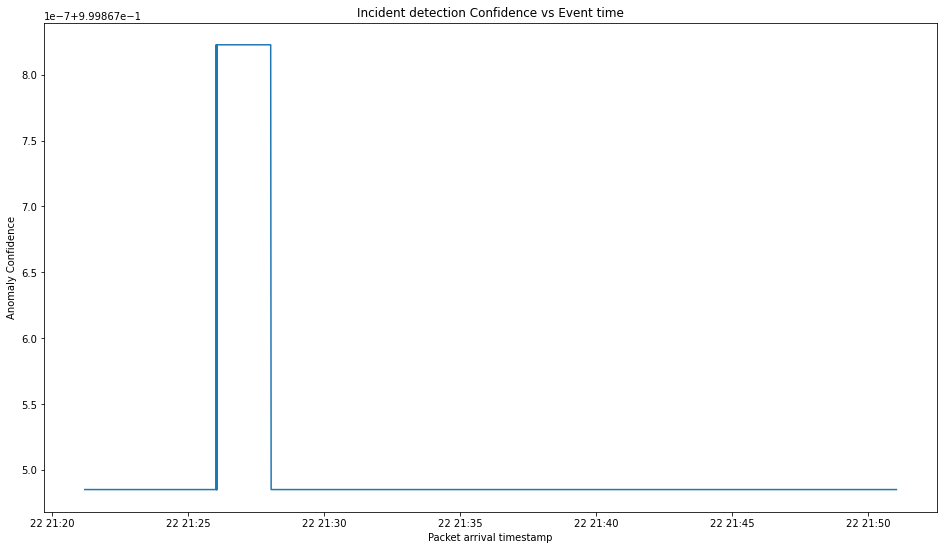

In [4]:
from numpy import array, linspace
from sklearn.neighbors import KernelDensity
from matplotlib.pyplot import plot
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

import datetime as dt
dates=[datetime.fromtimestamp(ts[0]) for ts in detected]

values=[x[1] for x in detected]
probs=[x[2] for x in detected]
k = [x for x in detected if x[1]==0]
#print(k)
fig, ax = plt.subplots(figsize=(16,9))
ax.title.set_text("Incident detection Confidence vs Event time")
ax.set_xlabel('Packet arrival timestamp')
ax.set_ylabel('Anomaly Confidence')
#ax.plot(dates,values)
ax.plot(dates,probs, label='Anomaly Detection Confidence')


# Normal data from .251 , Attack Data from .50